# CHEM E 545: Midterm Project (60 points)

In this project, we want to predict biodegradibility of different compounds. Supervised Machine Learning (SML) is an important tool that can take into account multiple attributes about a compound including its chemical structure and predict its biodegradability in the environment. SML models can help in figuring out which chemicals are going to be environment friendly helping in making responsible choices during chemical selection for different processes/products.

In this project, wherever you need to use a random_state/seed use the number 100. All plots should have title and labels 

## Part (a): Regression Task 

###  Data Preparation: (15 points)
Load the data file. Your data contains a feature called as 'Smiles'. The simplified molecular-input line-entry system (SMILES) is a specification in the form of a line notation for describing the structure of chemical species using short ASCII strings. You can read more [here](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system). 

We want to convert this string to actual molecular descriptors. <b> Hint </b>: You will have a total of 209 descriptors for each Smiles string. You can do that by using [rdkit](https://www.rdkit.org/) package and its descriptors. You can import these as follows:


In [1]:
!pip install rdkit
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import RDLogger #to ignore the error 'WARNING: not removing hydrogen atom without neighbors' 
RDLogger.DisableLog('rdApp.*')   #should allow the code to run faster on the dataset

In [2]:
# import all packages needed
import matplotlib.pyplot as plt
import matplotlib as mpl # For colormaping
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
from sklearn.linear_model import LinearRegression # for linear regression modeling
from sklearn.linear_model import LogisticRegression # for logistic regression modeling
from sklearn.model_selection import train_test_split # train split test

from sklearn.preprocessing import OrdinalEncoder # encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn import metrics # for confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # for confusion matrix

Other than smiles, your dataset has 5 other features and one target/output variable (biodegradation percentage). You are trying to build a model using all the features to predict the percentage biodegradation. Therefore, combine the 209 descriptors  with the 5 remaining features from your dataset. Next, remove any rows that contains NaNs. Finally, remove any feature that still contains a smiles string and the feature 'Ipc'. 

In [3]:
# print the shape of your resultant x(input) and y (output) data 
# reading a csv file using pandas
RegData = pd.read_excel("reg_data_545_midterm.xlsx") #read in the "reg_data_545_midterm" csv data file as a pandas dataframe
RegData.head(10) #output the first 10 entries in the dataframe
RegData.shape #printing the shape of the data
#NOTE: for the "Biodegradtion" column 1 is biodegradable and 0 is not biodegradable

(10000, 7)

In [4]:
#read in data frame to manipulate the data
newMolDF=pd.read_csv('MolDescriptors.csv')
newMolDF.head(5) #check the first 5 entries of this dataframe
newMolDF.shape #checking the shape (10000, 211) but for the 209 descriptors two of these columns are indices and can be dropped from the dataframe  

(10000, 211)

In [5]:
RegData.columns #check the columns in the original RegData dataframe

Index(['Smiles', 'Reliability', 'Type', 'StandardTest', 'System_setup',
       'reaction_time', 'Biodegradation'],
      dtype='object')

In [6]:
newMolDF[RegData.columns]=RegData #this will add the data from the columns of the original RegData
newMolDF.head() #outputting dataframe
#newMolDF.shape #checking the shape (10000, 218)

,Unnamed: 0,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_thiophene,fr_unbrch_alkane,fr_urea,Smiles,Reliability,Type,StandardTest,System_setup,reaction_time,Biodegradation
0,0,6.320833,6.320833,0.000000,0.000000,0.519261,55.250000,187.714,169.570,187.112777,...,0,0,0,NC12CC3CC(CC(C3)C1)C2.[Cl-].[H+],2,Inherent,Test 302 B,DOC Die Away,28.0,0.10
1,1,6.491327,6.491327,1.027346,-2.511080,0.569960,11.333333,253.204,243.124,251.992882,...,0,0,0,Cl[Si](Cl)(c1ccccc1)c1ccccc1,1,Ready,Test 301 C,Closed Respirometer,28.0,0.00
2,2,11.378134,11.378134,0.716093,-1.077315,0.349414,11.058824,317.710,309.646,315.931862,...,0,0,0,[O-][n+]1ccccc1[S-][Zn+2][S-]c1cccc[n+]1[O-],1,Ready,Test 301 B,CO2 Evolution,8.0,0.17
3,3,10.101122,10.101122,0.363519,0.363519,0.553535,14.800000,142.242,124.098,142.135765,...,0,0,0,CC(CC=O)CC(C)(C)C,1,Ready,Test 301 C,Closed Respirometer,28.0,0.07
4,4,13.332122,13.332122,0.009210,-0.009210,0.299012,12.160000,320.351,308.255,320.094963,...,0,0,0,O=c1c2cccc3cccc(c32)c2nc3cccc4cccc(c43)n12,1,Ready,Test 301 F,Closed Respirometer,14.0,0.01


In [7]:
MolRegDataDF=newMolDF.drop(columns=["Smiles","Ipc","Unnamed: 0"]) #use pandas.DataFrame.drop to drop "Smiles" and "Ipc" columns from the dataframe 
MolRegDataDF.head(10) #outputting 10 entries of the dataframe
#MolRegDataDF.shape #checking the shape after dropping the rows (10000,215)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Reliability,Type,StandardTest,System_setup,reaction_time,Biodegradation
0,6.320833,6.320833,0.000000,0.000000,0.519261,55.250000,187.714,169.570,187.112777,70,...,0,0,0,0,2,Inherent,Test 302 B,DOC Die Away,28.0,0.1000
1,6.491327,6.491327,1.027346,-2.511080,0.569960,11.333333,253.204,243.124,251.992882,76,...,0,0,0,0,1,Ready,Test 301 C,Closed Respirometer,28.0,0.0000
2,11.378134,11.378134,0.716093,-1.077315,0.349414,11.058824,317.710,309.646,315.931862,84,...,0,0,0,0,1,Ready,Test 301 B,CO2 Evolution,8.0,0.1700
3,10.101122,10.101122,0.363519,0.363519,0.553535,14.800000,142.242,124.098,142.135765,60,...,0,0,0,0,1,Ready,Test 301 C,Closed Respirometer,28.0,0.0700
4,13.332122,13.332122,0.009210,-0.009210,0.299012,12.160000,320.351,308.255,320.094963,116,...,0,0,0,0,1,Ready,Test 301 F,Closed Respirometer,14.0,0.0100
5,10.818153,10.818153,0.576637,-0.908344,0.315336,13.000000,458.001,429.777,457.180857,168,...,0,0,0,0,1,Ready,Test 301 B,CO2 Evolution,28.0,0.0593
6,11.409419,11.409419,0.010559,-0.010559,0.326266,10.947368,270.457,236.185,270.255880,114,...,0,0,7,0,2,Ready,Test 301 B,CO2 Evolution,21.0,0.9620
7,10.875594,10.875594,0.006997,-0.449559,0.674514,9.777778,259.290,250.218,259.041548,90,...,0,1,0,0,1,Ready,EU Method C.4-E,Closed Bottle Test,10.0,0.0000
8,13.366204,13.366204,0.152937,-1.392342,0.336524,18.000000,382.365,360.189,382.128577,152,...,0,0,0,0,1,Ready,Test 301 B,CO2 Evolution,28.0,0.0000
9,11.713279,11.713279,0.000000,-1.436540,0.261805,11.423077,395.581,361.309,395.207405,146,...,0,0,9,0,1,Ready,Test 301 D,Closed Bottle Test,14.0,0.6430


In [8]:
MolRegDF=MolRegDataDF.dropna() #use pandas.DataFrame.dropna to drop "NAN" rows from the dataframe 
MolRegDF.head() #outputting 5 entries of the dataframe
#MolRegDF.shape #checking the shape after dropping the rows (8832,215)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Reliability,Type,StandardTest,System_setup,reaction_time,Biodegradation
0,6.320833,6.320833,0.000000,0.000000,0.519261,55.250000,187.714,169.570,187.112777,70,...,0,0,0,0,2,Inherent,Test 302 B,DOC Die Away,28.0,0.1000
1,6.491327,6.491327,1.027346,-2.511080,0.569960,11.333333,253.204,243.124,251.992882,76,...,0,0,0,0,1,Ready,Test 301 C,Closed Respirometer,28.0,0.0000
3,10.101122,10.101122,0.363519,0.363519,0.553535,14.800000,142.242,124.098,142.135765,60,...,0,0,0,0,1,Ready,Test 301 C,Closed Respirometer,28.0,0.0700
4,13.332122,13.332122,0.009210,-0.009210,0.299012,12.160000,320.351,308.255,320.094963,116,...,0,0,0,0,1,Ready,Test 301 F,Closed Respirometer,14.0,0.0100
5,10.818153,10.818153,0.576637,-0.908344,0.315336,13.000000,458.001,429.777,457.180857,168,...,0,0,0,0,1,Ready,Test 301 B,CO2 Evolution,28.0,0.0593


###  Model Developement and Testing: (15 points)

Implement linear regression using your data. Plot the boxplot of R2 values for a test split of [0.4,0.35,0.3,0.25,0.2,0.1]. Also plot your predicted and actual values as a scatter plot at the test split of 0.1. 

#sklearn numpy arrays error:dimensions of y
categorical data encoding 

a=1
b=2
c=3 
label encoding
red hot encoding= binary zero when it is not, 1 when it is 
w
sklearn functions from columns 
strings to numbers
reshape (#rows, #col) only on numpy arrays
reshape (len(__) or -1 ,1 )

In [9]:
MolRegDF.shape

(8832, 215)

In [10]:
print(MolRegDF['StandardTest'].value_counts())
print(MolRegDF['Type'].value_counts())
print(MolRegDF['System_setup'].value_counts())

StandardTest
Test 301 F         1957
Test 301 B         1920
Test 301 C         1507
Test 301 D         1426
Test 302 B          578
Test 301 A          332
Test 310            249
Test 302 C          231
Test 301 E          225
EU Method C.4-D     150
EU Method C.4-E     109
EU Method C.4-A      95
EU Method C.4-C      53
Name: count, dtype: int64
Type
Ready       8023
Inherent     809
Name: count, dtype: int64
System_setup
Closed Respirometer    3863
CO2 Evolution          1973
Closed Bottle Test     1766
DOC Die Away           1230
Name: count, dtype: int64


In [11]:
# use ordinal encoder for Type and one-hot encorder for the other two
o_enc = OrdinalEncoder()
oh_enc = OneHotEncoder(sparse_output=False)
#make standard scaler funciton
scaler = StandardScaler()

#make matrix with feature data
X = MolRegDF.drop(columns=['Biodegradation'])

# Check which categories are string variables
cat = X.select_dtypes(include=[object])
cat_cols=cat.columns

#extract columns with numeric variables to be normalized
num = X.select_dtypes(include=[float,int])
num_cols=num.columns

scaler.fit(num)
num_scaled=scaler.transform(num.values.reshape(8832,-1))
num_scaled=pd.DataFrame(num_scaled)
num_scaled.columns = num_cols

# Type column encoding
encoded_type = o_enc.fit_transform(X['Type'].values.reshape(8832,-1)) # 0 = inherent, 1 = ready
encoded_type = pd.DataFrame(encoded_type)
encoded_type.columns = o_enc.get_feature_names_out(['Type'])

# StandardTest column encoding
encoded_stdtest = oh_enc.fit_transform(X['StandardTest'].values.reshape(8832,-1))
encoded_stdtest = pd.DataFrame(encoded_stdtest) # convert np.array into pd.dataframe
encoded_stdtest.columns = oh_enc.get_feature_names_out(['StandardTest']) # name columns by each class/feature

# System_setup column encoding
encoded_syssetup = oh_enc.fit_transform(X['System_setup'].values.reshape(8832,-1))
encoded_syssetup = pd.DataFrame(encoded_syssetup)
encoded_syssetup.columns = oh_enc.get_feature_names_out(['System_setup'])

# Join encoded columns back to a unified dataframe
X_enc = num_scaled.join([encoded_type,encoded_stdtest,encoded_syssetup])
X_enc.shape

/home/jackhoye/~miniconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(8832, 229)

In [12]:
# MolRegDF: final dataframe used for model (defined in previous part)
LinReg = LinearRegression() 
from sklearn.model_selection import train_test_split
y = MolRegDF['Biodegradation']

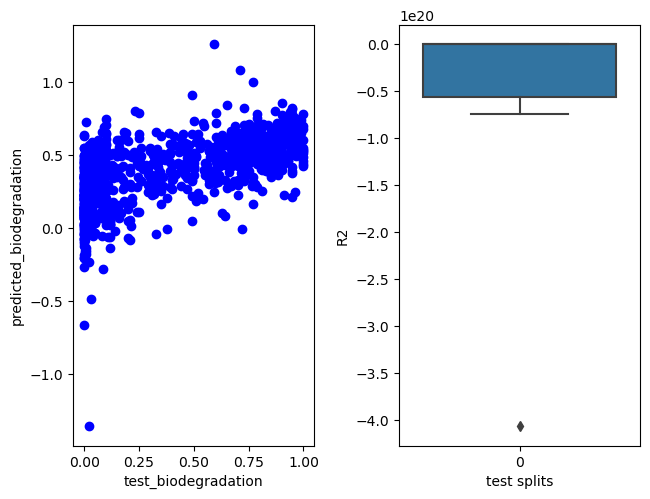

[-4.0656593434476695e+20, 0.32268936655574676, -7.458680163434114e+19, 0.3183607410118784, 0.33410778371996874, 0.35282659727346655]


In [13]:
# Split Test Training
from sklearn.metrics import r2_score
figa,axa = plt.subplots(1,2)
figa.tight_layout(h_pad=3,w_pad=3)
split_size = [0.4,0.35,0.3,0.25,0.2,0.1]
R2 = []

for i in range(len(split_size)):
    x_train,x_test,y_train,y_test = train_test_split(X_enc,y,test_size =split_size[i],random_state=100)
    LinReg.fit(x_train,y_train)
    y_pred=LinReg.predict(x_test)
    R2.append(r2_score(y_test, y_pred)) # calculate R2 score of the split test groups (is this correct?)
    
    if split_size[i] == 0.1:
        y_predicted = LinReg.predict(x_test)
        axa[0].scatter(y_test,y_predicted,color='b',label="Predicted vs. Test") # confused of what to plot here. x_test is a multi-column matrix so I ploted y_predicted vs. y_test here

sns.boxplot(R2,ax=axa[1])
axa[0].set(xlabel="test_biodegradation",ylabel="predicted_biodegradation")
axa[1].set(xlabel="test splits",ylabel="R2",
           #ylim=[-5,1]
          )
plt.show()
print(R2)

### Something New (5 points)

Implement any regression model of your choice that we haven't learnt in the class. Print the R2 value

In [14]:
X_enc.to_csv('X_enc_a.csv')
y.to_csv('y_a.csv')
#kernel kept crashing and I needed to restart enough times that it became helpful to save the data and not need to re-run everything above


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression # for linear regression modeling
from sklearn.model_selection import train_test_split # train split test
LinReg=LinearRegression()
X_enc=pd.read_csv('X_enc_a.csv')
y_csv=pd.read_csv('y_a.csv')
y=y_csv['Biodegradation'] #imports and cuts out original position data, only need biodegradataion data

In [16]:
#Implement a new regression algorithm of your choice here
#from skitlearn regressors just choose another one 

#from sklearn.preprocessing import PolynomialFeatures #imports polynomial regression package from sklearn
#poly=PolynomialFeatures(degree=2,include_bias=False) #Creates instance of PolynomialFeatures with 2nd order polynomial output. Bias=false so y-int!=0 by default
#poly_features=poly.fit_transform(X_enc)
#X_train,X_test,y_train,y_test = train_test_split(poly_features,y,test_size =0.1,random_state=100)

#combination of fit and transform. This will transform our x matrix into x and x^2 for use in the model
#Polynomial regression is still a linear combination of our variables into the model, so LinearRegression() can be used to preform the actual regression
#LinReg.fit(poly_features,y)

#This cell is very data intensive, and will likely crash the kernel. Best advice is to skip this cell unless you're curious about results
#The problematic cells are commented out, but can be reactivted by removing the "#" key from the lines beginning with "from sklearn..." and until the "X_train,X_test..."

In [17]:
#PolyModel1=LinReg.fit(X_train,y_train) #<-- this will invariably cause the jupyter kernel to run out of available memory.
#I wrote this code into a new notebook hosted on my local machine (submitted along with the project, named "PolynomialRegressionCalculator"
#Given that it wont't run properly, in this notebook, I'll comment the R2 value and leave a PNG in it's own cell

In [19]:
#from sklearn.metrics import r2_score
#y_pred=LinReg.predict(X_test)
#ax.scatter(y_test,y_pred)
#ax.set_xlabel('Test Biodegradation Values')
#ax.set_ylabel('Predicted Biodegradation Values')
#ax.set_title('Polynomial Regression Biodegradation Prediction Model',y=1.1)
#print('R2 value is:',r2_score(y_test, y_pred))

R2 value is: -54223900562.59358

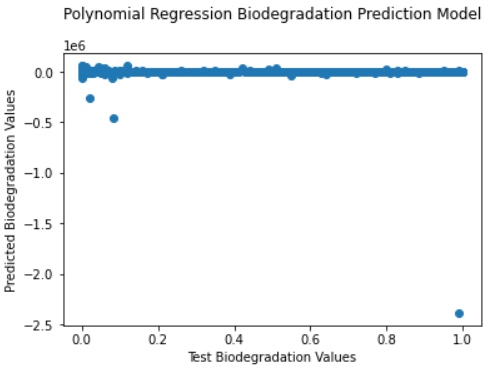

## Part (b): Classification Task 


### Data Preparation (5 points)
Load the data file. Your data contains a feature called as 'Smiles'. Use the same code as before to convert it into actual molecular descriptors. <b> Hint </b>: You will have a total of 209 descriptors for each Smiles string. Next, remove any rows that contains NaNs. Finally, remove any feature that still contains a smiles string and the feature 'Ipc'. Class labels of 0 and 1 are also provided in the data file. 

In [20]:
# print the shape of your resultant x(input) and y (output) data 
import pandas as pd
# reading a csv file using pandas
ClassData = pd.read_excel("class_data_545_midterm.xlsx") #read in the "reg_data_545_midterm" csv data file as a pandas dataframe
ClassData.head(10) #output the first 10 entries in the dataframe
#ClassData.shape #printing the shape of the data

,Smiles,Class
0,COc1c2occc2cc2ccc(=O)oc12,0
1,CCCCC(CC)COC(=O)C(C#N)=C(c1ccccc1)c1ccc(OC)cc1,0
2,C[C@H](CO)CCCC1CCCCC1,1
3,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@]2(C)[...,1
4,CCCCCCCCCCCCCCC/C=C/CC1CC(=O)OC1=O,0
5,CC(C)=CCC/C(C)=C/CO,1
6,CCC1(C/C=C2\CCCc3cc(OC)ccc32)C(=O)CCC1=O,0
7,CCNc1nc(NC(C)C)nc(SC)n1,0
8,C=CCCCC(C)C,1
9,CN(CCCN)CCCN,1


In [21]:
#implementing iteration to build a new dataframe
classLoc=ClassData.loc[(0),['Smiles']].values[0] #to index in the RegData dataframe at the location of the row in the column "Smiles"
MolDescriptor=Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(classLoc)) #to get molecular descriptors from rdkit at the above index
classDF = pd.DataFrame(MolDescriptor, index=[0]) #converting to a dataframe
#this starts off the new dataframe to later concatenate within the "for" loop

for i in range(len(ClassData["Smiles"])-1):  #iterating in the range of the Smiles column length -1
    molIters=ClassData.loc[(i+1),['Smiles']].values[0] #this gives just the values in the Smiles string for the ith row in the "Smiles" column, which will increase in index
    molDescripts=Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(molIters)) #to get molecular descriptors from rdkit at the above index
    classDF.loc[len(classDF.index)] = molDescripts #this will add another row to the above "molDF" dataframe
    
display(classDF) #read out the dataframe

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.173100,11.173100,0.405828,-0.405828,0.586359,11.062500,216.192,208.128,216.042259,80,...,0,0,0,0,0,0,0,0,0,0
1,12.852376,12.852376,0.020103,-0.572111,0.292535,12.482759,391.511,362.279,391.214744,152,...,0,0,0,0,0,0,0,0,0,0
2,8.871743,8.871743,0.365741,0.365741,0.694302,21.692308,184.323,160.131,184.182715,78,...,0,0,0,0,0,0,0,0,0,0
3,11.700542,11.700542,0.088987,-0.100305,0.737699,51.952381,286.415,260.207,286.193280,114,...,0,0,0,0,0,0,0,0,0,0
4,11.299171,11.299171,0.240375,-0.375099,0.137965,17.560000,350.543,312.239,350.282095,144,...,0,0,0,0,0,0,0,0,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,13.258107,13.258107,0.059355,-4.771851,0.321004,11.842105,544.861,530.749,544.086571,194,...,0,0,0,0,1,0,0,0,0,0
3996,11.446157,11.446157,0.366852,0.366852,0.567161,32.909091,154.253,136.109,154.135765,64,...,0,0,0,0,0,0,0,0,0,0
3997,10.203017,10.203017,0.184583,-0.184583,0.542210,9.777778,130.187,116.075,130.099380,54,...,0,0,0,0,0,0,0,0,0,0
3998,5.349815,5.349815,0.000000,0.000000,0.322813,13.904762,305.149,281.965,305.177394,120,...,0,0,0,0,0,0,0,0,2,0


In [22]:
classDF.to_csv('ClassDescriptors.csv') #this will save the values to a csv
#this will save the data from the previous cell into a csv file to only run this cell once

In [23]:
#read in data frame to manipulate the data
newClassDF=pd.read_csv('ClassDescriptors.csv')#read in the "reg_data_545_midterm" csv data file as a pandas dataframe
newClassDF.head(5) #check the first 5 entries of this dataframe
#newClassDF.shape #checking the shape (4000, 211) but for the 209 descriptors two of these columns are indices and can be dropped from the dataframe  

,Unnamed: 0,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,11.173100,11.173100,0.405828,-0.405828,0.586359,11.062500,216.192,208.128,216.042259,...,0,0,0,0,0,0,0,0,0,0
1,1,12.852376,12.852376,0.020103,-0.572111,0.292535,12.482759,391.511,362.279,391.214744,...,0,0,0,0,0,0,0,0,0,0
2,2,8.871743,8.871743,0.365741,0.365741,0.694302,21.692308,184.323,160.131,184.182715,...,0,0,0,0,0,0,0,0,0,0
3,3,11.700542,11.700542,0.088987,-0.100305,0.737699,51.952381,286.415,260.207,286.193280,...,0,0,0,0,0,0,0,0,0,0
4,4,11.299171,11.299171,0.240375,-0.375099,0.137965,17.560000,350.543,312.239,350.282095,...,0,0,0,0,0,0,0,0,12,0


In [24]:
newClassDF[ClassData.columns]=ClassData #this will add the data from the columns of the original ClassData frame
newClassDF.head() #outputting dataframe
#newClassDF.shape #checking the shape (4000, 213)

,Unnamed: 0,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Smiles,Class
0,0,11.173100,11.173100,0.405828,-0.405828,0.586359,11.062500,216.192,208.128,216.042259,...,0,0,0,0,0,0,0,0,COc1c2occc2cc2ccc(=O)oc12,0
1,1,12.852376,12.852376,0.020103,-0.572111,0.292535,12.482759,391.511,362.279,391.214744,...,0,0,0,0,0,0,0,0,CCCCC(CC)COC(=O)C(C#N)=C(c1ccccc1)c1ccc(OC)cc1,0
2,2,8.871743,8.871743,0.365741,0.365741,0.694302,21.692308,184.323,160.131,184.182715,...,0,0,0,0,0,0,0,0,C[C@H](CO)CCCC1CCCCC1,1
3,3,11.700542,11.700542,0.088987,-0.100305,0.737699,51.952381,286.415,260.207,286.193280,...,0,0,0,0,0,0,0,0,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@]2(C)[...,1
4,4,11.299171,11.299171,0.240375,-0.375099,0.137965,17.560000,350.543,312.239,350.282095,...,0,0,0,0,0,0,12,0,CCCCCCCCCCCCCCC/C=C/CC1CC(=O)OC1=O,0


In [25]:
MolClassDataDF=newClassDF.drop(columns=["Smiles","Ipc","Unnamed: 0"]) #use pandas.DataFrame.drop to drop "Smiles" and "Ipc" columns from the dataframe 
MolClassDataDF.head(25) #outputting 10 entries of the dataframe
#MolClassDataDF.shape #checking the shape after dropping the rows (4000,210)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Class
0,11.173100,11.173100,0.405828,-0.405828,0.586359,11.062500,216.192,208.128,216.042259,80,...,0,0,0,0,0,0,0,0,0,0
1,12.852376,12.852376,0.020103,-0.572111,0.292535,12.482759,391.511,362.279,391.214744,152,...,0,0,0,0,0,0,0,0,0,0
2,8.871743,8.871743,0.365741,0.365741,0.694302,21.692308,184.323,160.131,184.182715,78,...,0,0,0,0,0,0,0,0,0,1
3,11.700542,11.700542,0.088987,-0.100305,0.737699,51.952381,286.415,260.207,286.193280,114,...,0,0,0,0,0,0,0,0,0,1
4,11.299171,11.299171,0.240375,-0.375099,0.137965,17.560000,350.543,312.239,350.282095,144,...,0,0,0,0,0,0,0,12,0,0
5,8.553384,8.553384,0.167316,0.167316,0.617131,11.454545,154.253,136.109,154.135765,64,...,0,0,0,0,0,0,0,0,0,1
6,12.272888,12.272888,0.132050,-0.752896,0.785027,21.565217,312.409,288.217,312.172545,122,...,0,0,0,0,0,0,0,0,0,0
7,4.263927,4.263927,0.316280,0.316280,0.748463,10.466667,227.337,210.201,227.120467,84,...,0,0,0,0,0,0,0,0,0,0
8,3.657529,3.657529,0.856435,0.856435,0.387161,9.875000,112.216,96.088,112.125201,48,...,0,0,0,0,0,0,0,1,0,1
9,5.354111,5.354111,0.784687,0.784687,0.535274,10.800000,145.250,126.098,145.157898,62,...,0,0,0,0,0,0,0,0,0,1


In [26]:
MolClassDF=MolClassDataDF.dropna() #use pandas.DataFrame.dropna to drop "NAN" rows from the dataframe 
MolClassDF.head(5) #outputting 5 entries of the dataframe
#MolClassDF.shape #checking the shape after dropping the rows (3544,210)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Class
0,11.173100,11.173100,0.405828,-0.405828,0.586359,11.062500,216.192,208.128,216.042259,80,...,0,0,0,0,0,0,0,0,0,0
1,12.852376,12.852376,0.020103,-0.572111,0.292535,12.482759,391.511,362.279,391.214744,152,...,0,0,0,0,0,0,0,0,0,0
2,8.871743,8.871743,0.365741,0.365741,0.694302,21.692308,184.323,160.131,184.182715,78,...,0,0,0,0,0,0,0,0,0,1
3,11.700542,11.700542,0.088987,-0.100305,0.737699,51.952381,286.415,260.207,286.193280,114,...,0,0,0,0,0,0,0,0,0,1
4,11.299171,11.299171,0.240375,-0.375099,0.137965,17.560000,350.543,312.239,350.282095,144,...,0,0,0,0,0,0,0,12,0,0


###  Model Developement and Testing: (15 points)

Implement Logistic Regression. Do you notice something when you use the default solver? Use the solver 'newton-cholesky' to see if the issue resolves. Why could this be happening? Print the test accuracy and the confusion matrix for the test data. Use a test split of 0.2

In [27]:
from sklearn.linear_model import LogisticRegression
# Multinomial logistic regression used here
X_multi = MolClassDF.drop(columns=['Class']) # X dataset, (3544,209)
Y_multi = MolClassDF['Class'] # Class column

# Split data into test/training sets, test split = 0.2
from sklearn.model_selection import train_test_split
x_train_log,x_test_log,y_train_log,y_test_log = train_test_split(X_multi,Y_multi,test_size=0.2,random_state=100)

# Multinomial Logistic Regression with lbfgs (default solver)
LogReg = LogisticRegression(C=1.0,random_state=100)
LogReg.fit(x_train_log,y_train_log)

/home/jackhoye/~miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=100)

**Issue shown when using the default solver: lbfgs**
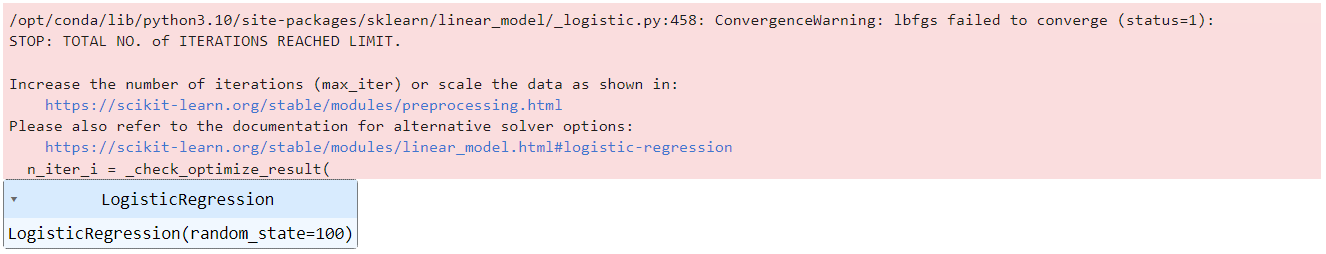
Possible explanation: the solver failed to converge because there are too many samples, so that the limited-memory solver can only store and process limited amount of dataset at once (at default max.iteration = 100).\
According to documentations of sklearn, "newton-cholesky" solver is useful when n_samples >> n_features; therefore, with 209 descriptors associated with the class (0,1) this solver is a better choice.

In [28]:
# Logistic Regression with newton-cholesky solver
LogReg_nc = LogisticRegression(C=1.0,random_state=100,solver='newton-cholesky')
LogReg_nc.fit(x_train_log,y_train_log)

# test accuracy
print("training set accuracy score is : {:.3f}" .format(LogReg_nc.score(x_train_log,y_train_log)))
print("test set accuracy score is : {:.3f}" .format(LogReg_nc.score(x_test_log,y_test_log)))

training set accuracy score is : 0.810
test set accuracy score is : 0.787


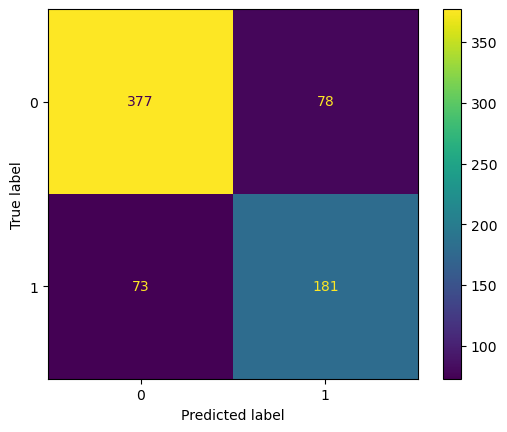

In [29]:
# Confusion matrix
y_test_log_pred = LogReg_nc.predict(x_test_log)
ConfusionMatrixDisplay.from_predictions(y_test_log,y_test_log_pred)

### Something New (5 points)
Plot the ROC curve using the test data for the logistic regression model implemented above

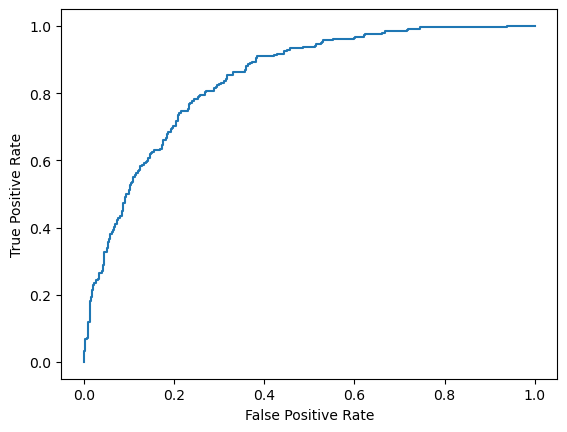

In [30]:
y_pred_prob=LogReg.predict_proba(x_test_log)[::,1] #test data from the model
fpr,tpr,_=metrics.roc_curve(y_test_log,y_pred_prob) #calculates false and true positive rates from sklearn function roc_curve
plt.plot(fpr,tpr) #plot false positive vs true positive
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()